In [26]:
'''
Script to plot the overall epidemiology of Cook County
Data  pulled from IDPH and CDPH since hospitalizations for IDPH were not recorded before June 13th
'''

import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

#data pulled from IDPH and CDPH
chicago_only = pd.read_csv('/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/COVID-19_Daily_Cases__Deaths__and_Hospitalizations.csv')


In [27]:
chicago_only['Date'] = pd.to_datetime(chicago_only['Date'])
chicago_only = chicago_only.sort_values(by='Date')

In [28]:
chicago_only = chicago_only.reset_index()

In [29]:
#getting all the necessary file paths
age_files = ! ls '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_age/'
gender_files = ! ls '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_gender/'
race_files = ! ls '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_race/'
cases_files = ! ls '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_Cases_tests_deaths/'
hosp_files = ! ls '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_Hospitalizations/'
vax_files = ! ls '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_Vaccinations/'

path = '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_Vaccinations/'
vax_df = pd.DataFrame()
for file in vax_files:
    tmp = pd.read_csv(path+file)
    print(file, tmp.shape)
    for d in range(len(tmp['ReportDate'])):
        vax_df.at[tmp['ReportDate'].iloc[d], file] = tmp['PersonsFullyVaccinated'].iloc[d]





IDPHExport20220405044003912.csv (458, 10)
IDPHExport20220405044012526.csv (457, 10)


In [30]:
#creating the master dataframe with all needed features
names = ['cases', 'hosp', 'Vaccinations']

total_df = pd.DataFrame()
cases_dict = {}
tests_dict = {}

for o in range(len([cases_files, hosp_files, vax_files])):
    outcome = [cases_files, hosp_files, vax_files][o]
    if names[o] == 'cases':
        folder = '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_Cases_tests_deaths/'
    elif names[o] == 'hosp':
        folder = '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_Hospitalizations/'
    else:
        folder = '/Users/tlh4362/Desktop/hultquist_lab/Chicago Epi/ClinicalDataForTed/data_used/IDPH_Vaccinations/'
    for file in outcome: 
        tmp = pd.read_csv(folder+file)
        for d in range(len(tmp['ReportDate'])):
            if names[o] == 'cases':
                colname = file+'_case_count'
                total_df.at[tmp['ReportDate'].iloc[d], colname] = tmp['CasesChange'].iloc[d]
                
                cases_dict[tmp['ReportDate'].iloc[d]] = cases_dict.get(tmp['ReportDate'].iloc[d], 0) + tmp['CasesChange'].iloc[d]
                tests_dict[tmp['ReportDate'].iloc[d]] = tests_dict.get(tmp['ReportDate'].iloc[d], 0) + tmp['TotalTestedChange'].iloc[d]

                colname = file+'_deaths'
                total_df.at[tmp['ReportDate'].iloc[d], colname] = tmp['DeathsChange'].iloc[d]
                
                colname = file+'_TotalTestedChange'
                total_df.at[tmp['ReportDate'].iloc[d], colname] = tmp['TotalTestedChange'].iloc[d]
                
            elif names[o] == 'hosp':
                colname = file+'_hosp'
                total_df.at[tmp['ReportDate'].iloc[d], colname] = tmp['CLIAdmissions_RollingAvg'].iloc[d]

            else:
                colname = file+'_Vaccinations'
                total_df.at[tmp['ReportDate'].iloc[d], colname] = tmp['PersonsFullyVaccinated'].iloc[d]



In [31]:
total_df['percent_fully_vaccinated'] = total_df.loc[:,['IDPHExport20220405044003912.csv_Vaccinations','IDPHExport20220405044012526.csv_Vaccinations']].sum(axis = 1)/5275541 #total cook county population


In [32]:
#hospitalization for IDPH was not available before June 13th, so we used CDPH hospitalization data as a proxy from March 17th, 2020 to June 13th, 2020.
total_df.index = pd.to_datetime(total_df.index)
for i in range(len(total_df)):
    end_date = pd.to_datetime('2020-06-13')
    to_match = total_df.index[i]
    if to_match == end_date:
        break
    else:
        hosp = chicago_only[chicago_only['Date']==to_match]['Hospitalizations - Total'].iloc[0]
        total_df.at[to_match, 'IDPHExport20220202114605524.csv_hosp'] = hosp


In [33]:
total_df.index = [str(x).split(' 00:')[0] for x in total_df.index]
x_tick_labels = pd.Series([x[0:7] for x in total_df.index])

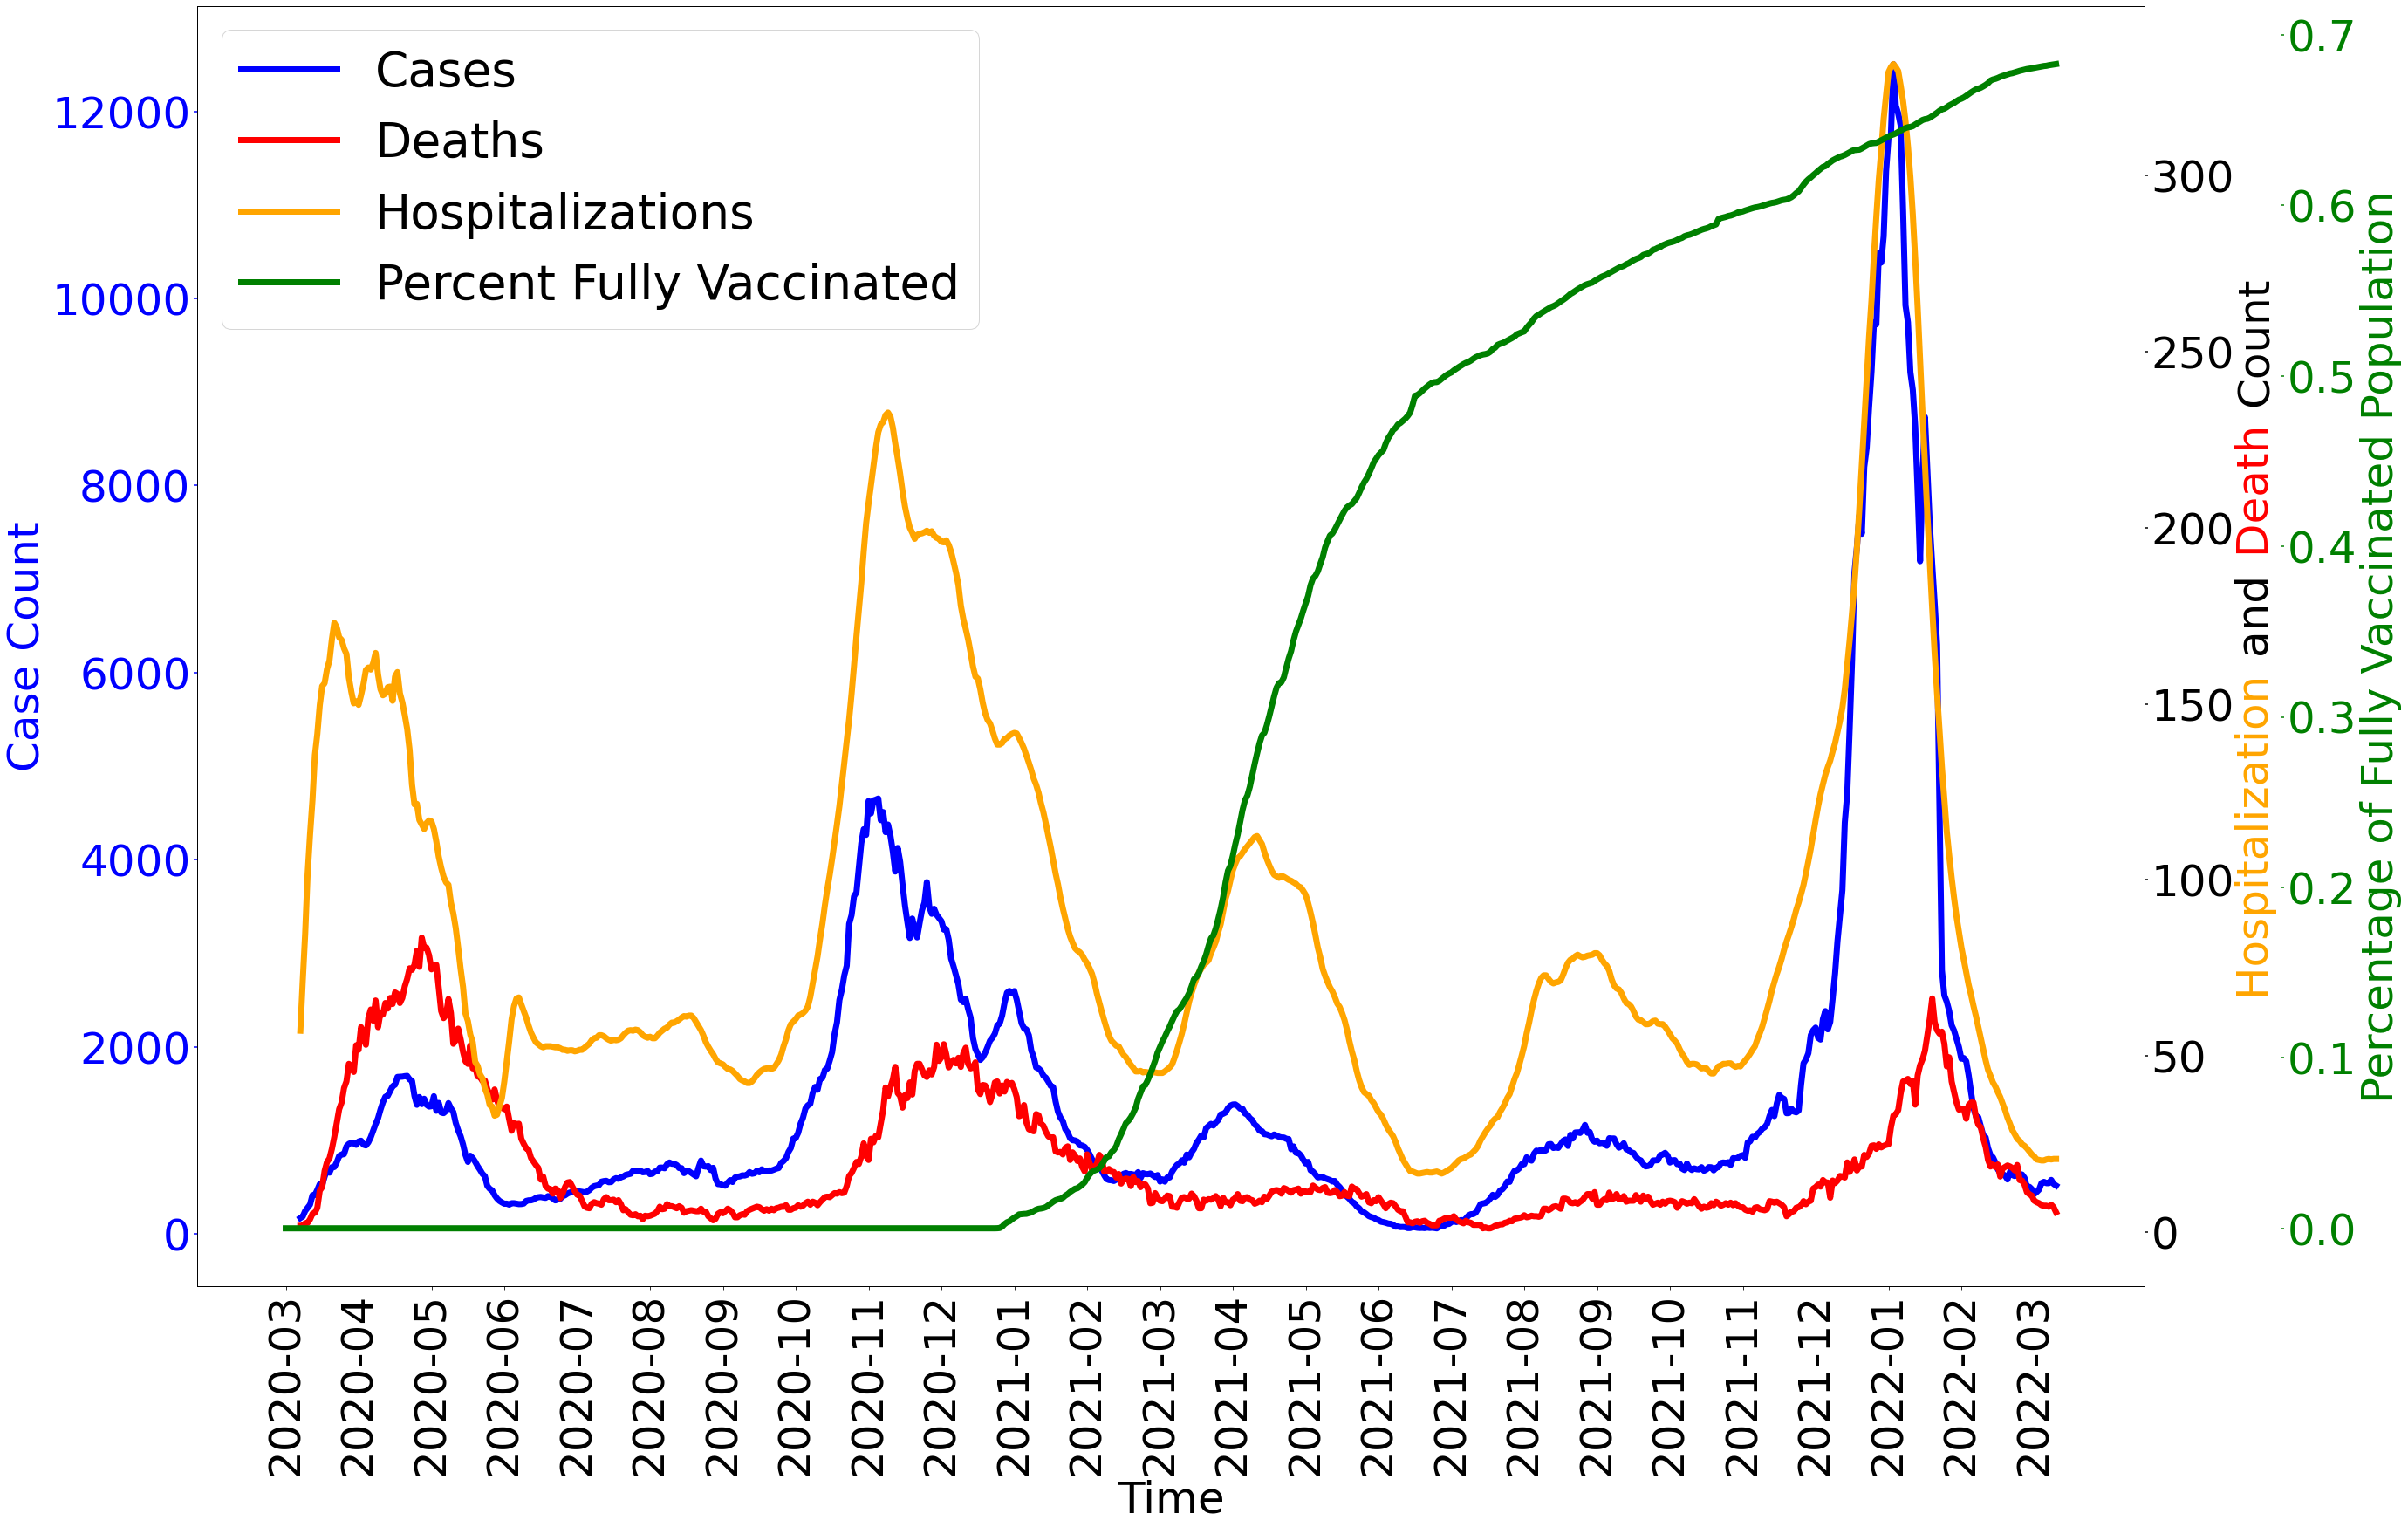

In [34]:

#plotting all cases, hospitalizations, deaths and proportion of fully vaccinated individuals

fig, ax = plt.subplots(figsize = [40,27])
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.07))

for o in ['case_count','deaths','hosp', 'vax']:
    moving_average = []
    tmp_df = total_df.filter(regex=o).sum(axis = 1)

    name = o +'_moving average'
    if o == 'case_count':
        p1, = ax.plot(tmp_df.rolling(7).mean(), label = 'Cases', color = 'blue', linewidth=7)
    elif o == 'deaths':
        p21, = ax2.plot(tmp_df.rolling(7).mean(), label = 'Deaths', color = 'red', linewidth=7)
    elif o == 'hosp':
        p22, = ax2.plot(tmp_df.rolling(7).mean(), label = 'Hospitalizations', color = 'orange', linewidth=7)
    else:
        p3, = ax3.plot(total_df['percent_fully_vaccinated'],  label = 'Percent Fully Vaccinated', color = 'green', linewidth=7)

        plt.xticks(rotation = 90, fontsize = 25)

ax.set_xlabel('Time', fontsize = 50)
ax.set_ylabel('Case Count', fontsize = 50)

# ax2.set_ylabel('Hospitalization and Death Count' , fontsize = 50)
ybox1 = TextArea("Hospitalization ", textprops=dict(color="orange", size=50,rotation=90,ha='left',va='bottom'))
ybox2 = TextArea("and ",     textprops=dict(color="black", size=50,rotation=90,ha='left',va='bottom'))
ybox3 = TextArea("Death ", textprops=dict(color="red", size=50,rotation=90,ha='left',va='bottom'))

ybox4 = TextArea("Count", textprops=dict(color="black", size=50,rotation=90,ha='left',va='bottom'))

ybox = VPacker(children=[ybox4, ybox3, ybox2, ybox1],align="bottom", pad=0, sep=5)
anchored_ybox = AnchoredOffsetbox(loc='center right', child=ybox, pad=0., frameon=False, bbox_to_anchor=(1.068, 0.5), 
                                  bbox_transform=ax2.transAxes, borderpad=0.)
ax2.add_artist(anchored_ybox)
ax3.set_ylabel('Percentage of Fully Vaccinated Population', fontsize = 50)
        
ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color('purple')
ax3.yaxis.label.set_color(p3.get_color())


tkw = dict(size=4, width=1.5, labelsize = 50)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors='black', **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)

ax.set_xticks(range(0,len(total_df.index),30))

ax.set_xticklabels( x_tick_labels[range(0,len(total_df.index),30)], rotation = 90, fontsize = 50)

ax.legend(handles = [p1, p21, p22, p3], fontsize = 55)



# plt.title('7-day Moving Average of Cases, Hospitalizations and Deaths of COVID-19 in Chicago with Vaccination Rate', fontsize = 40)
# plt.savefig('/Users/tlh4362/Desktop/figure_1a.eps',bbox_inches='tight', format='eps')
plt.show()


